In [1]:
import numpy as np
import pandas as pd
import os

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np

import copy 

In [319]:
%matplotlib inline

In [3]:
%matplotlib qt

# Get real positions

Load finger positions

In [4]:
positionFingersLeft = pd.read_excel("C:/Users/lucas/Desktop/UPC/MIT/tactile2object/manus/New Session-002.xlsx", sheet_name="ns1 positionFingersLeft")
positionFingersRight = pd.read_excel("C:/Users/lucas/Desktop/UPC/MIT/tactile2object/manus/New Session-002.xlsx", sheet_name="ns1 positionFingersRight")

In [5]:
positionFingers = pd.concat([positionFingersLeft, positionFingersRight], axis=1)

x_positions = [position for position in list(positionFingers.columns) if "_x" in position]
y_positions = [position for position in list(positionFingers.columns) if "_y" in position]
z_positions = [position for position in list(positionFingers.columns) if "_z" in position]

positions = [position.split("_")[0] for position in list(positionFingers.columns)]
# Remove duplicates
positions = list(dict.fromkeys(positions))

Choose finger we are using to touch object and frames where is touching to get position

In [6]:
def getBonePosition(bone, frames):
    touch_position = {}

    for frame in frames:
        touch_position[frame] = [
            positionFingers.loc[frame, bone + "_x"] * 1000,
            positionFingers.loc[frame, bone + "_y"] * 1000,
            positionFingers.loc[frame, bone + "_z"] * 1000
        ]
        
    return touch_position

def getBonesPosition(bones, frames):
    bones_dict = {}
    
    for bone in bones:
        bones_dict[bone] = getBonePosition(bone, frames)

    return bones_dict

In [7]:
bone = "LeftSecondDP"
frames = [5042, 5217, 5443, 5660]
frames = [5900, 6009, 6190, 6340, 6423, 6645, 6791, 6888, 7125, 7237, 7401, 7527, 7690]
frames = [5900, 6009, 6190, 6340]

touch_position = getBonePosition(bone, frames)

In [8]:
touch_position

{5900: [-250.473, 54.027, 1216.027],
 6009: [-245.327, 53.129000000000005, 1285.2939999999999],
 6190: [-200.427, -25.412, 1302.937],
 6340: [-234.423, -22.311, 1075.932]}

In [9]:
keypoint_world_position = np.zeros((4,3))

for i, frame in enumerate(frames):
    keypoint_world_position[i,:] = touch_position[frame]

# Get object locations

In [10]:
import os
import open3d as o3d
import numpy as np

import seaborn as sns

In [11]:
def pick_points(pcd):
    """
    http://www.open3d.org/docs/tutorial/Advanced/interactive_visualization.html
    :param pcd: open3d point cloud data
    :return: None
    """
    print("")
    print("1) Please pick at least three correspondences using [shift + left click]")
    print("   Press [shift + right click] to undo point picking")
    print("2) Afther picking points, press q for close the window")
    vis = o3d.visualization.VisualizerWithEditing()
    vis.create_window()
    vis.add_geometry(pcd)
    vis.run()  # user picks points
    vis.destroy_window()
    print("")
    return vis.get_picked_points()

In [12]:
def load_point_cloud(mesh_path: str):
    """
    Currently o3d doesn't support obj file, thus we need some
    hacky solution here
    :param mesh_path: Full path to an ply/obj file
    :return:
    """
    if mesh_path.endswith('.ply'):
        return o3d.io.read_point_cloud(mesh_path)
    elif mesh_path.endswith('.obj'):
        raise NotImplementedError()
    else:
        raise RuntimeError('Unknown data format')

Touch the points as below. [6800, 5942, 3587, 151]


1 | 2 | 3 | 4
- | - | - | - 
![alt](yunzhu_touching_035/5900.png) | ![alt](yunzhu_touching_035/6009.png) | ![alt](yunzhu_touching_035/6190.png) | ![alt](yunzhu_touching_035/6340.png)

In [13]:
mesh_path = "C:/Users/lucas/Desktop/UPC/MIT/tactile2object/estimate_object_pose/ycb_converted/035_power_drill.ply"

assert os.path.exists(mesh_path)
pcd = load_point_cloud(mesh_path)
# Scale pointcloud
pcd.scale(0.8, center=pcd.get_center()) #center=(0, 0, 0)
picked_ids = [6800, 5942, 3587, 151] # pick_points(pcd) 

# Extract the keypoint in world
point_cloud = np.asarray(pcd.points)
keypoint_3d_position = []
for point_id in picked_ids:
    point_in_world = point_cloud[point_id, :]
    keypoint_3d_position.append([float(point_in_world[0]), float(point_in_world[1]), float(point_in_world[2])])

# Save them to a map
data_map = dict()
data_map['mesh_path'] = mesh_path
data_map['keypoint_index'] = picked_ids
data_map['keypoint_world_position'] = keypoint_3d_position

# ICP

In [14]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from math import sin, cos, atan2, pi
from IPython.display import display, Math, Latex, Markdown, HTML

In [348]:
def center_data(data, exclude_indices=[]):
    reduced_data = np.delete(data, exclude_indices, axis=1)
    center = np.array([reduced_data.mean(axis=1)]).T
    return center, data - center

def compute_cross_covariance(P, Q, correspondences, kernel=lambda diff: 1.0):
    cov = np.zeros((3, 3))
    exclude_indices = []
    for i, j in correspondences:
        p_point = P[:, [i]]
        q_point = Q[:, [j]]
        weight = kernel(p_point - q_point)
        if weight < 0.01: exclude_indices.append(i)
        cov += weight * q_point.dot(p_point.T)
    return cov, exclude_indices

def get_correspondence_indices(P, Q):
    p_size = P.shape[1]
    q_size = Q.shape[1]
    correspondences = []
    
    for i in range(p_size):
        correspondences.append((i, i))

    return correspondences

def plot_values(values, label):
    plt.rcParams['figure.dpi'] = 100
    plt.rcParams['savefig.dpi'] = 100
    sns.set_theme()
    fig = plt.figure(figsize=(10, 4))
    ax = fig.add_subplot(111)
    ax.plot(values[:2], label=label)
    ax.legend()
    ax.grid(True)
    ax.set_ylim(0)
    ax.set_xlabel("")
    plt.show()

def plot_bar_values(values):
    plt.rcParams['figure.dpi'] = 100
    plt.rcParams['savefig.dpi'] = 100
    sns.set_theme()
    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_subplot(111)
    ax.bar(["Before ICP", "After ICP"], values[:2])
    ax.grid(True)
    ax.set_ylim(0)
    ax.set_ylabel("Distance")
    ax.set_title("Distance between pointclouds")
    plt.show()

def icp_svd(P, Q, iterations=10, kernel=lambda diff: 1.0):
    """Perform ICP using SVD."""
    center_of_Q, Q_centered = center_data(Q)
    norm_values = []
    R_values = []
    t_values = []
    P_values = [P.copy()]
    P_copy = P.copy()
    corresp_values = []
    exclude_indices = []
    for i in range(iterations):
        center_of_P, P_centered = center_data(P_copy, exclude_indices=exclude_indices)
        
        correspondences = get_correspondence_indices(P_centered, Q_centered)
        corresp_values.append(correspondences)
        norm_values.append(np.linalg.norm(P_centered - Q_centered))
        cov, exclude_indices = compute_cross_covariance(P_centered, Q_centered, correspondences, kernel)
        U, S, V_T = np.linalg.svd(cov)
        R = U.dot(V_T)  
        t = center_of_Q - R.dot(center_of_P)  
        
        P_copy = R.dot(P_copy) + t
        P_values.append(P_copy)
        R_values.append(R)
        t_values.append(t)
    corresp_values.append(corresp_values[-1])
    
    return P_values, norm_values, corresp_values, R_values, t_values

In [16]:
Q = np.array(data_map['keypoint_world_position']).T
P = np.array(keypoint_world_position).T


P_values, norm_values, corresp_values, R, t = icp_svd(P, Q)
plot_values(norm_values, label="Squared diff P->Q")

# Plot results

In [17]:
pcd.paint_uniform_color([0.3, 0.3, 0.3])

PointCloud with 8194 points.

#### Toching points in simulation

In [18]:
balls_sim = []

for xyz_sim in data_map['keypoint_world_position']:
    ball_sim = o3d.geometry.TriangleMesh.create_sphere(radius=2.).translate((xyz_sim))
    ball_sim.paint_uniform_color([1, 0., 0])
    balls_sim.append(ball_sim)

In [19]:
visualize = [pcd] + balls_sim

o3d.visualization.draw_geometries(visualize)

#### Touching points in real object

In [20]:
balls_real = []

for xyz_real in keypoint_world_position:
    ball_real = o3d.geometry.TriangleMesh.create_sphere(radius=2.).translate((xyz_real))
    ball_real.paint_uniform_color([0, 1., 0])
    balls_real.append(ball_real)

In [21]:
visualize = [pcd] + balls_sim + balls_real
o3d.visualization.draw_geometries(visualize)

#### Translate and rotate real points to be in the object. 

In [22]:
points_tr = (R[0].dot(keypoint_world_position.T) + t[0]).T

balls_real_tr = []
for point_tr in points_tr:
    ball_real_tr = o3d.geometry.TriangleMesh.create_sphere(radius=2.).translate((point_tr))
    ball_real_tr.paint_uniform_color([0, 1., 1])
    balls_real_tr.append(ball_real_tr)

In [23]:
visualize = [pcd] + balls_sim + balls_real_tr
o3d.visualization.draw_geometries(visualize)

#### Improve results by substracting movement of the other hand

In [24]:
reference_bones = ["RightCarpus", 
                   "RightFirstMC", "RightSecondMC", "RightThirdMC", "RightFourthMC", "RightFifthMC"]

In [25]:
bonesPositions = getBonesPosition(reference_bones, frames)
bonesPositions = pd.DataFrame.from_dict(bonesPositions)

Get mean of the different reference bones

In [26]:
frameMeans = {}

for frame in bonesPositions.T:
    frameBonesPositions = np.array([np.array(xi) for xi in bonesPositions.loc[frame, :]])
    frameMean = frameBonesPositions.mean(axis=0)
    
    frameMeans[frame] = frameMean

Compute the movement of the frame with respect to the first one

In [27]:
movementFrame = {}

for frame in frames:
    movementFrame[frame] = frameMeans[frame] - frameMeans[frames[0]]

In [28]:
movement = np.zeros((len(frames), 3))

for i, frame in enumerate(frames):
    movement[i,:] = movementFrame[frame]

Correct position of the other hand

In [29]:
keypoint_world_position_corrected = keypoint_world_position - movement

In [30]:
Q = np.array(data_map['keypoint_world_position']).T
P = np.array(keypoint_world_position_corrected).T


P_values, norm_values, corresp_values, R, t = icp_svd(P, Q)
#plot_values(norm_values, label="Squared diff P->Q")

In [31]:
points_tr_corrected = (R[0].dot(keypoint_world_position_corrected.T) + t[0]).T

balls_real_tr_corrected = []
for point_tr in points_tr_corrected:
    ball_real_tr = o3d.geometry.TriangleMesh.create_sphere(radius=2.).translate((point_tr))
    ball_real_tr.paint_uniform_color([0, 1., 0])
    balls_real_tr_corrected.append(ball_real_tr)

In [32]:
visualize = [pcd] + balls_sim + balls_real_tr + balls_real_tr_corrected
o3d.visualization.draw_geometries(visualize)

### Try different scales

In [38]:
values = []
scales = np.arange(0.1, 2, 0.1)
for scale in scales:
    mesh_path = "C:/Users/lucas/Desktop/UPC/MIT/tactile2object/estimate_object_pose/ycb_converted/035_power_drill.ply"

    assert os.path.exists(mesh_path)
    pcd = load_point_cloud(mesh_path)
    # Scale pointcloud
    pcd.scale(scale, center=pcd.get_center()) #center=(0, 0, 0)
    picked_ids = [6800, 5942, 3587, 151] # pick_points(pcd) 

    # Extract the keypoint in world
    point_cloud = np.asarray(pcd.points)
    keypoint_3d_position = []
    for point_id in picked_ids:
        point_in_world = point_cloud[point_id, :]
        keypoint_3d_position.append([float(point_in_world[0]), float(point_in_world[1]), float(point_in_world[2])])

    # Save them to a map
    data_map = dict()
    data_map['mesh_path'] = mesh_path
    data_map['keypoint_index'] = picked_ids
    data_map['keypoint_world_position'] = keypoint_3d_position
    
    
    Q = np.array(data_map['keypoint_world_position']).T
    P = np.array(keypoint_world_position).T


    _, norm_values, *_ = icp_svd(P, Q)
    values.append(norm_values[-1])
    
import matplotlib.pyplot as plt
plt.plot(scales, values)
plt.xlabel('Scale')
plt.ylabel('Distance between pointclouds')
plt.show()

# Multiple points

In [383]:
def get_lines(points1, points2):
    line_points = []
    line_lines = []

    for i in range(points_real.shape[0]):
        line_points.append(points1[i,:])
        line_points.append(points2[i,:])

        line_lines.append([i*2, i*2+1])


    line_points = np.array(line_points)
    line_lines = np.array(line_lines)
    
    line_set = o3d.geometry.LineSet()
    line_set.points = o3d.utility.Vector3dVector(line_points)
    line_set.lines = o3d.utility.Vector2iVector(line_lines)
    colors = [[0, 0, 1] for i in range(len(line_lines))]
    line_set.colors = o3d.utility.Vector3dVector(colors)
    
    return line_set

In [390]:
def get_sim_points(mesh_path, picked_ids = None, scale=1.):
    assert os.path.exists(mesh_path)
    pcd = load_point_cloud(mesh_path)
    pcd.paint_uniform_color([0.3, 0.3, 0.3])
    # Scale pointcloud
    pcd.scale(scale, center=pcd.get_center()) #center=(0, 0, 0) pcd.get_center()
    

    if picked_ids == None:
        picked_ids = pick_points(pcd)


    # Extract the keypoint in world
    point_cloud = np.asarray(pcd.points)
    keypoint_3d_position = []
    for point_id in picked_ids:
        point_in_world = point_cloud[point_id, :]
        keypoint_3d_position.append([float(point_in_world[0]), float(point_in_world[1]), float(point_in_world[2])])

    # Save them to a map
    data_map = dict()
    data_map['mesh_path'] = mesh_path
    data_map['keypoint_index'] = picked_ids
    data_map['keypoint_world_position'] = keypoint_3d_position
    
    return  pcd, np.array(keypoint_3d_position)

In [391]:
def get_balls(points, color=[1,0,0], radius=3.):
    balls = []
    
    for xyz in points:
        ball = o3d.geometry.TriangleMesh.create_sphere(radius=radius).translate((xyz))
        ball.paint_uniform_color(color)
        balls.append(ball)
        
    return balls

In [392]:
def getAvgBonePosition(bone, frames):
    positions = np.zeros((len(frames), 3))
    
    for i, frame in enumerate(frames):
        positions[i,:] = [
            positionFingers.loc[frame, bone + "_x"] * 1000,
            positionFingers.loc[frame, bone + "_y"] * 1000,
            positionFingers.loc[frame, bone + "_z"] * 1000
        ]
        
    return np.mean(positions, axis=0) #.tolist()

In [393]:
red = [225/255, 87/255, 89/255]
orange = [242/255, 142/255, 43/255]
yellow = [237/255, 201/255, 72/255]
blue = [78/255, 121/255, 167/255]
green = [89/255, 161/255, 79/255]


1 | 2 | 3 |
- | - | - |
5900, 6791, 7401 | 6009, 6888, 7237 | 6190, 7125 |
![alt](yunzhu_touching_035/5900.png) | ![alt](yunzhu_touching_035/6009.png) | ![alt](yunzhu_touching_035/6190.png) 

4 | 5 | 6 |
- | - | - | 
6340, 6645, 7527 | 6423 | 7690 |
![alt](yunzhu_touching_035/6340.png) | ![alt](yunzhu_touching_035/6423.png) | ![alt](yunzhu_touching_035/7690.png) | ![alt](yunzhu_touching_035/6340.png)



### Get simulated points

In [394]:
mesh_path = "C:/Users/lucas/Desktop/UPC/MIT/tactile2object/estimate_object_pose/ycb_converted/035_power_drill.ply"

picked_ids = [6796, 5958, 3626, 153, 563, 4257]
pcd, points_sim = get_sim_points(mesh_path, picked_ids, scale=0.8)

In [395]:
ball_sim = get_balls(points_sim)

visualize = balls_sim + [pcd]

o3d.visualization.draw_geometries(visualize, zoom=0.9,
                                  front=[0.0, 0.0, -0.5],
                                  lookat=[0.0, 0.0, 0.0],
                                  up=[0.0, 0.4, 0.0])

### Get real points

In [396]:
frames_touching = [
    [5900, 6791, 7401],
    [6009, 6888, 7237],
    [6190, 7125],
    [6340, 6645, 7527],
    [6423],
    [7690],
]

positions_real = []

for frames in frames_touching:
    positions_real.append(getAvgBonePosition(bone, frames))
    
points_real = np.array(positions_real)

In [397]:
balls_real = get_balls(points_real, color=green)

line_set = get_lines(points_real, points_sim)


visualize = [pcd] + balls_sim + balls_real + [line_set]

o3d.visualization.draw_geometries(visualize, zoom=0.9,
                                  front=[0.0, 0.0, -0.5],
                                  lookat=[0.0, 0.0, 0.0],
                                  up=[0.0, 0.4, 0.0])

### ICP

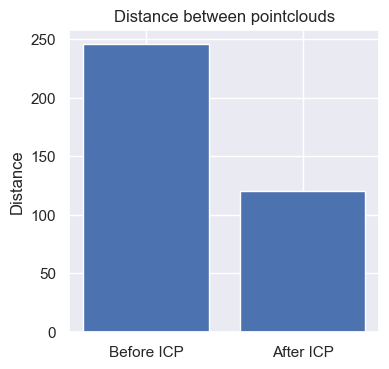

In [398]:
Q = np.array(points_sim).T
P = np.array(points_real).T


P_values, norm_values, corresp_values, R, t = icp_svd(P, Q)
plot_bar_values(norm_values)

### Translate and rotate points

In [399]:
points_real_tr = (R[0].dot(points_real.T) + t[0]).T

balls_real_tr = []
for point_tr in points_real_tr:
    ball_real_tr = o3d.geometry.TriangleMesh.create_sphere(radius=3.).translate((point_tr))
    ball_real_tr.paint_uniform_color(green)
    balls_real_tr.append(ball_real_tr)

In [400]:
line_set = get_lines(points_real_tr, points_sim)

visualize = [pcd] + balls_sim + balls_real_tr + [line_set]

o3d.visualization.draw_geometries(visualize, zoom=0.9,
                                  front=[0.0, 0.0, -0.5],
                                  lookat=[0.0, 0.0, 0.0],
                                  up=[0.0, 0.4, 0.0])

In [401]:
t[0]

array([[ -509.36930928],
       [-1007.25700939],
       [  445.66732261]])

In [402]:


R[0]

array([[ 0.35969569, -0.8196457 ,  0.44586986],
       [ 0.01237644,  0.48200177,  0.87608283],
       [ 0.93298758,  0.30960494, -0.18351825]])